# Compartmental models
Marco Caporaletti, Christian Stoppani 

## Summary of the assignment

This is a practical assignment on dynamic network models, infection spreading, immunization and influence. It consists of the following two tasks.

### Task 1

We study the dynamics of the infected share of the population Susceptible-Infected (SI) and Susceptible-Infected-Susceptible (SIS) models, and how this is affected by different network topologies and immunization strategies. We are required to:
1. Write a function to simulate the SI(S) model, run the simulation and visualize the final state of the epidemic on two given graphs
2. Simulate the SIS model on one given graph and show infected fraction as a function of time
3. Plot the (expected) stationary share infected for the SIS model as a function of $R_0 = \beta/\gamma$, for an Erdos-Renyi (ER) and a Barabasi-Albert (BA) network
4. Implement two immunization strategies: a) random immunization of a share $g\in[0,1]$ vs b) target immunization of the largest degree neighbour of each of a random fraction $g\in[0,1]$ of nodes. Compare their performance on a BA network by running the epidemics simulations and plot the stationary share infected as a function of $g$ for both immunization strategies


### Task 2

We study nodes' spreading ability vs their centrality in the Susceptible-Infected-Recovered (SIR) model. We are required to:
1. Write a function to simulate the SIR dynamics and visualize each node's spreading ability. We simulate the dynamics on a BA network and a 1D regular lattice
2. Compute the correlation of spreading ability and centrality for each of the following centrality measures: degree, closeness, PageRank and k-core centrality, as a function of the model parameters. We visualize this for an ER, a BA and a Watts-Strogaz (WS) graph.
3. Visualize the correlation between spreading ability and centrality in a scatter plot for each of the centrality measures and graphs in 2.
4. Repeat 3. on real-world networks provided



We start by importing the necessary modules and graphs

In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
from tqdm import tqdm
import scipy.stats as st

#1. Compartmental models
G1 = nx.read_gml('data/graph1.1.gml')
G2 = nx.read_gml('data/graph1.2.gml')

#2.Centralities and influence
jazz = nx.read_gml('data/graph_jazz_collab.gml')
madrid = nx.read_gml('data/graph_madrid.gml')

## Task 1: SI(S) and immunization

### 1.
We write a function to simulate the SIS model. As a special case, we recover the SI model by passing the argument gamma = 0 to the simulation function.

In [86]:
def sis_model_simulation(G, beta, gamma, infected_seeds, n_steps):
    """
    Simulate SIS dynamics on a network. 

    Parameters:
    - G: NetworkX graph
    - beta: infection rate
    - gamma: recovery rate (set = 0 to simlutate SI model instead)
    - infected_seeds: list containing nodes that are infected at t=0
    - n_steps: number of steps in the simulation.
    """

    # Initialize states: 0 = susceptible, 1 = infected
    states = {node: 1 if node in infected_seeds else 0 for node in G.nodes}

    # Initialize n_infected
    N = G.number_of_nodes()
    n_infected = [len(infected_seeds)/N]

    # Compute dictionary of neighbors
    neighbor_lists = {node: list(G.neighbors(node)) for node in G.nodes}

    for i in range(1,n_steps):

        # Create temporary variable
        old_states = states.copy() 

        # Initialize N_infected
        N_infected = 0

        # Loop over nodes
        for node in G.nodes:

            # If susceptible, become infected with probability beta
            if old_states[node] == 0: 
                infected_neighbors = sum(old_states[neighbor] == 1 for neighbor in neighbor_lists[node])
                infection_prob = 1 - (1 - beta)**infected_neighbors
                if np.random.rand() < infection_prob:
                    states[node] = 1
            
            # If infected, become susceptible with probability gamma
            else:
                if np.random.rand() < gamma:
                    states[node] = 0

            N_infected += states[node]
        
        n_infected.append(N_infected/N)

    return n_infected, states



We write functions to plot the final state of the epidemic and one to plot the fraction of infected nodes as a function of time.

In [111]:
def plot_states(G, states):
    """
    Plot the final state of nodes in a graph.

    Parameters:
    - G: NetworkX graph
    - states: Dictionary mapping nodes to their states (0 for susceptible, 1 for infected)
    """
    plt.figure(figsize=(8, 8))
    pos = nx.kamada_kawai_layout(G)

    # Separate nodes based on their states
    susceptible_nodes = [node for node, state in states.items() if state == 0]
    infected_nodes = [node for node, state in states.items() if state == 1]

    # Draw susceptible nodes in blue
    nx.draw_networkx_nodes(G, pos, nodelist=susceptible_nodes, node_color='blue', node_size=300, alpha=0.8, label='Susceptible')

    # Draw infected nodes in red
    nx.draw_networkx_nodes(G, pos, nodelist=infected_nodes, node_color='red', node_size=300, alpha=0.8, label='Infected')

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black', font_weight='bold')

    # Create legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Susceptible'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Infected')
    ]

    # Add legend
    plt.legend(handles=legend_elements, loc='upper right')

    # Set plot title
    plt.title("Final Node States", fontsize=14)

    # Show the plot
    plt.show()

def moving_average(data, window_size):
    """
    Calculate the moving average of a given data series.

    Parameters:
    - data: List or array of data points
    - window_size: Size of the moving average window

    Returns:
    - moving_avg: Moving average of the data
    """

    # First compute the cumulative sum at each time (add a 0 at the beginning)
    cumsum = np.cumsum(np.insert(data, 0, 0))

    # Moving average is given by difference of cumulative sums at window_size distance, normalized with window_size
    moving_avg = (cumsum[window_size:] - cumsum[:-window_size]) / window_size

    return moving_avg

def plot_history(infected_fraction_history, window_size=5):
    """
    Plot the evolution of infected fraction with a moving average over time.

    Parameters:
    - infected_fraction_history: List representing the fraction of infected nodes at each step
    - window_size: Size of the moving average window (default is 5)
    """
    plt.figure(figsize=(14, 6))

    # Compute susceptible fraction
    susceptible_fraction_history = [1-n for n in infected_fraction_history]

    # Plot moving average (smoothed version) of infected and susceptible fraction evolution over time
    susceptible_moving_avg = moving_average(susceptible_fraction_history, window_size)
    infected_moving_avg = moving_average(infected_fraction_history, window_size)
    plt.plot(range(window_size - 1, len(infected_fraction_history)), susceptible_moving_avg, color='blue', label='Susceptible')
    plt.plot(range(window_size - 1, len(infected_fraction_history)), infected_moving_avg, color='red', label='Infected')

    # Add labels and title
    plt.xlabel("Time Step")
    plt.ylabel(f"Susceptible/Infected Fraction: MA (window size {window_size})")
    plt.title("Evolution of Susceptible/Infected Fraction Over Time", fontsize=14)

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

# Example usage for plot_final_state:
# (Assuming you have already simulated the SIS model and have a graph `graph` and states dictionary `simulation_results[-1]`)
# Replace with your actual graph and data.
# plot_final_state(graph, simulation_results[-1])

# Example usage for plot_history:
# (Assuming you have the infected fraction history list `infected_fraction_history`)
# Replace with your actual data.
# plot_history(infected_fraction_history)

We plot the results of the simulation for the first graph:

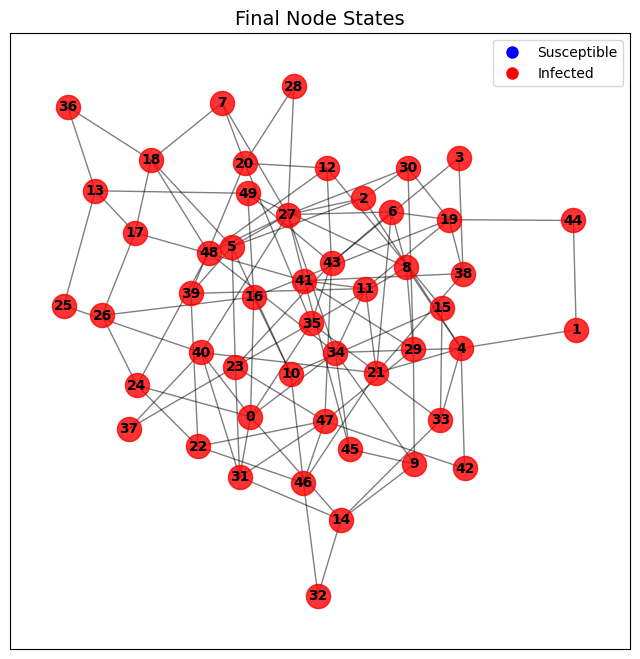

In [103]:
_, final_states = sis_model_simulation(G1, 0.5, 0, ['10'], 20)
plot_states(G1, final_states)

And for the second graph:

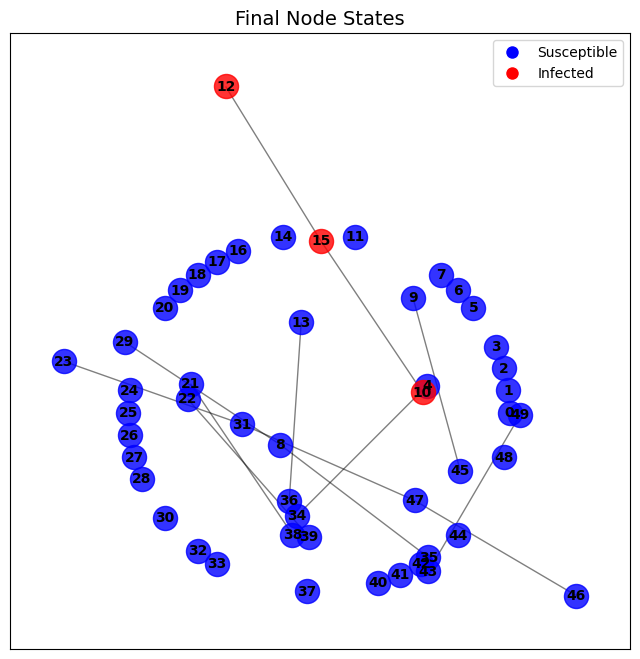

In [104]:
_, final_states = sis_model_simulation(G2, 0.5, 0, ['10'], 20)
plot_states(G2, final_states)

The second graph has very few edges, and in particular the connected component containing the seed has only three nodes, so the infection does not spread much.

### 2.

We plot the fraction of susceptible/infected nodes in graph1 under the SIS evolution.

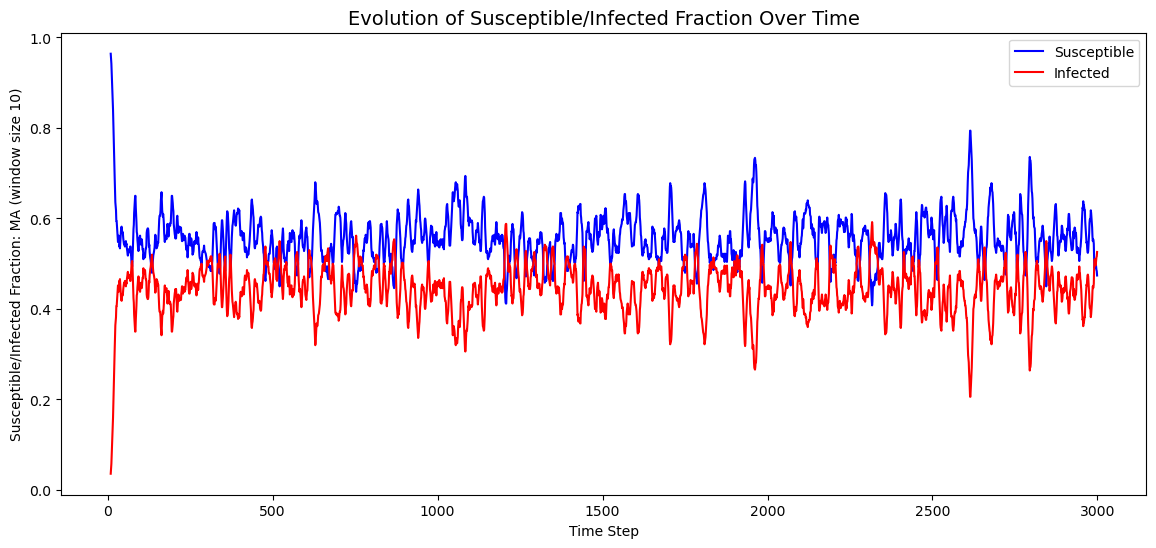

In [119]:
infected_history, _ = sis_model_simulation(G1, 0.2, 0.4, [np.random.choice(G1.nodes)], 3000)
plot_history(infected_history, window_size = 10)

### 3.
We plot a phase diagram for the SIS model on the ER and BA graphs.

First, we generate (and visualize) the two graphs:

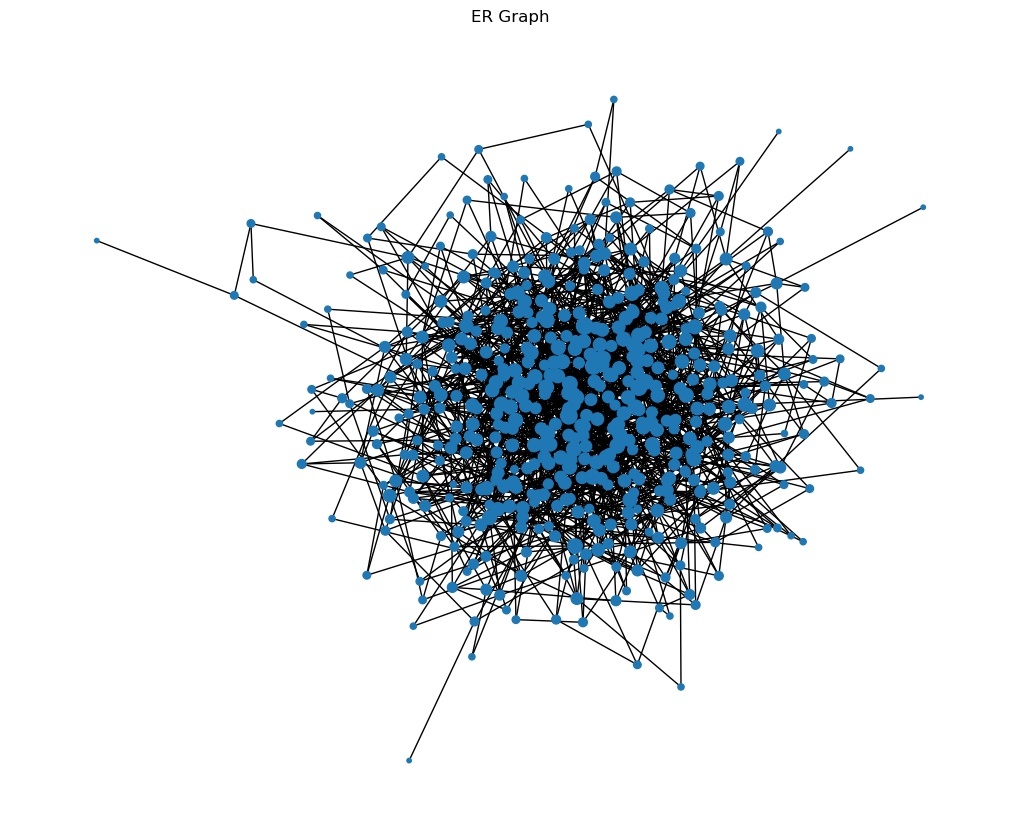

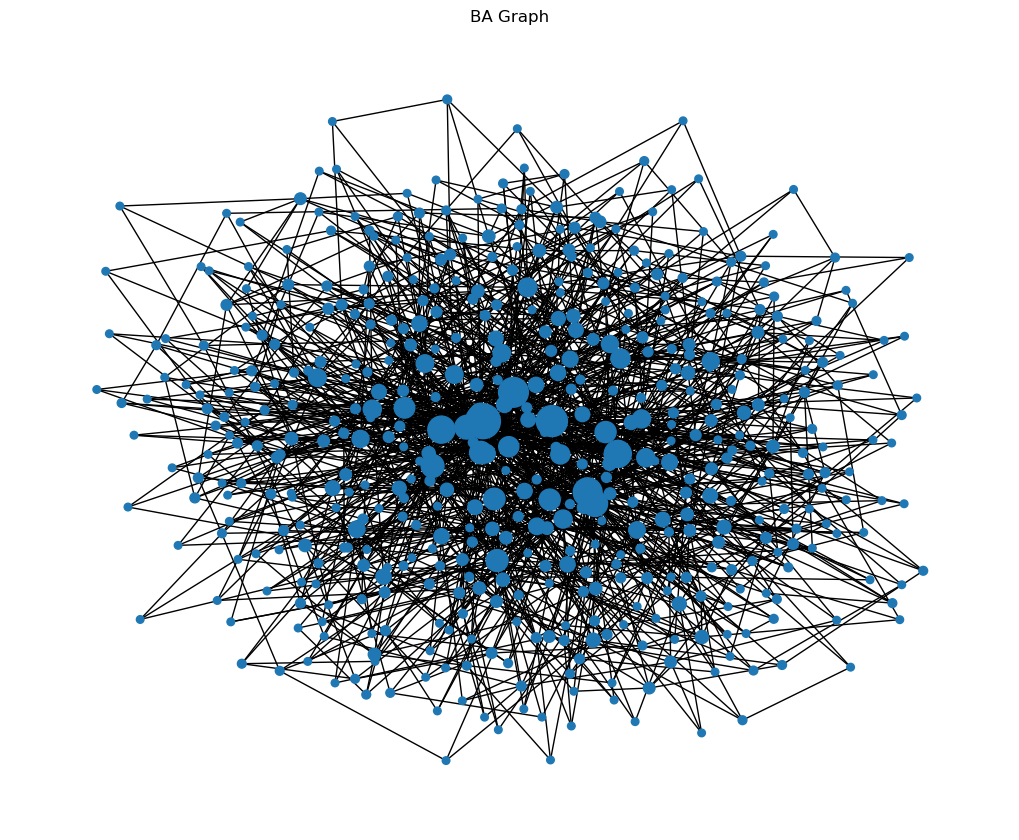

In [127]:
# Generate ER and BA graphs
N = 500
p_er = 6 / N
m_ba = 3

er_graph = nx.erdos_renyi_graph(N, p_er)
ba_graph = nx.barabasi_albert_graph(N, m_ba)

# Visualization
def plot_graph(graph, title):
    degrees = dict(graph.degree())
    node_sizes = [val * 10 for val in degrees.values()]  # Make node size proportional to degree for better visualization

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(graph, seed=42)
    nx.draw(graph, pos, with_labels=False, node_size=node_sizes)
    plt.title(title)
    plt.show()

plot_graph(er_graph, 'ER Graph')
plot_graph(ba_graph, 'BA Graph')

We next run the simulations for different values of beta/gamma.

In [132]:
# Set parameters
n_ratios = 15  
n_steps = 1000  # You can adjust this parameter
num_simulations = 100  

# Generate logarithmically spaced ratios
ratios = np.logspace(-2, 0, n_ratios)

# Initialize lists to store the average final fraction of infected nodes for each ratio
avg_final_fraction_er = []
avg_final_fraction_ba = []

for ratio in ratios:

    # Set beta and gamma between 0 and 1 to have correct ratio
    beta = ratio / (1 + ratio)
    gamma = 1 / (1 + ratio)

    # Initialize list to store final fraction for each simulation
    final_fractions_er = []
    final_fractions_ba = []

    for _ in tqdm(range(num_simulations), desc=f'Ratio {ratio:.3f}'):
        
        # Run SIS simulation on ER graph
        infected_history, _ = sis_model_simulation(er_graph, beta, gamma, [np.random.choice(er_graph.nodes)], n_steps)
        final_fractions_er.append(infected_history[-1])

        # Run SIS simulation on BA graph
        infected_history, _ = sis_model_simulation(ba_graph, beta, gamma, [np.random.choice(ba_graph.nodes)], n_steps)
        final_fractions_ba.append(infected_history[-1])

    # Calculate and store the average final fraction of infected nodes
    avg_final_fraction_er.append(np.mean(final_fractions_er))
    avg_final_fraction_ba.append(np.mean(final_fractions_ba))

Ratio 0.010:   0%|          | 0/100 [00:00<?, ?it/s]

Ratio 1.000: 100%|██████████| 100/100 [02:10<00:00,  1.30s/it]


Finally, we plot the final fraction of infected nodes as a function of beta/gamma:

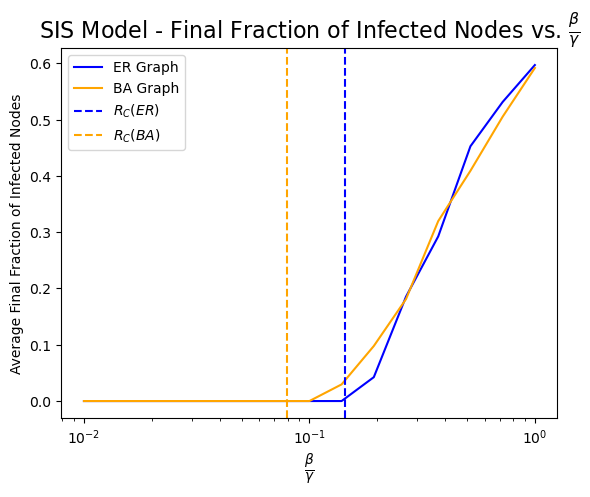

In [133]:
plt.plot(ratios, avg_final_fraction_er, color = 'blue', label='ER Graph')
plt.plot(ratios, avg_final_fraction_ba, color = 'orange', label='BA Graph')

# Logarithmic scale for better visualization
plt.xscale('log')  

# Add labels and title
plt.xlabel(r'$\frac{\beta}{\gamma}$', fontsize=14)
plt.ylabel('Average Final Fraction of Infected Nodes')
plt.title('SIS Model - Final Fraction of Infected Nodes vs. ' + r'$\frac{\beta}{\gamma}$', fontsize=16)

# Add legend
plt.legend()

# Compute the average degree and average squared degree
average_degree_er = np.mean([d for n, d in er_graph.degree()])
average_squared_degree_er = np.mean([d**2 for n, d in er_graph.degree()])

average_degree_ba = np.mean([d for n, d in ba_graph.degree()])
average_squared_degree_ba = np.mean([d**2 for n, d in ba_graph.degree()])

# Add vertical lines for critical epidemic thresholds

# Add vertical lines for corrected critical epidemic thresholds
plt.axvline(average_degree_er / average_squared_degree_er, color='blue', linestyle='--', label=r'$R_C(ER)$')
plt.axvline(average_degree_ba / average_squared_degree_ba, color='orange', linestyle='--', label=r'$R_C(BA)$')

plt.legend()
plt.show()

Although not requested, we also provide the same plot with linear spacing of the $\beta/\gamma$ values, because it looks a bit better and the phase transition is easier to see. 

In [135]:
ratios_lin = np.linspace(0, 1, n_ratios)

# Initialize lists to store the average final fraction of infected nodes for each ratio
avg_final_fraction_er_lin = []
avg_final_fraction_ba_lin = []

for ratio in ratios_lin:

    # Set beta and gamma between 0 and 1 to have correct ratio
    beta = ratio / (1 + ratio)
    gamma = 1 / (1 + ratio)

    # Initialize list to store final fraction for each simulation
    final_fractions_er = []
    final_fractions_ba = []

    for _ in tqdm(range(num_simulations), desc=f'Ratio {ratio:.3f}'):
        
        # Run SIS simulation on ER graph
        infected_history, _ = sis_model_simulation(er_graph, beta, gamma, [np.random.choice(er_graph.nodes)], n_steps)
        final_fractions_er.append(infected_history[-1])

        # Run SIS simulation on BA graph
        infected_history, _ = sis_model_simulation(ba_graph, beta, gamma, [np.random.choice(ba_graph.nodes)], n_steps)
        final_fractions_ba.append(infected_history[-1])

    # Calculate and store the average final fraction of infected nodes
    avg_final_fraction_er_lin.append(np.mean(final_fractions_er))
    avg_final_fraction_ba_lin.append(np.mean(final_fractions_ba))

Ratio 1.000: 100%|██████████| 100/100 [17:24<00:00, 10.44s/it]  


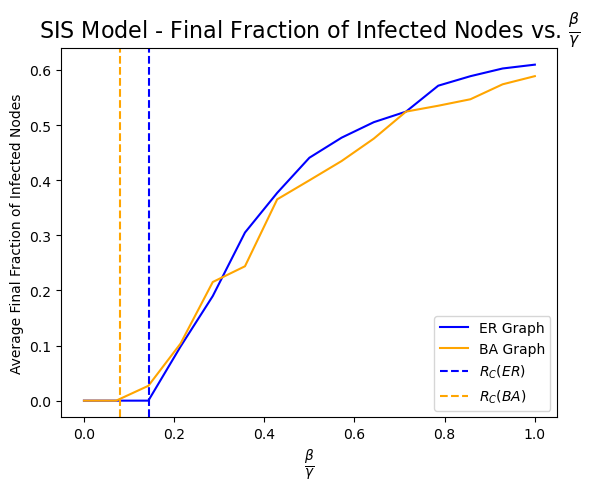

In [136]:
plt.plot(ratios_lin, avg_final_fraction_er_lin, color = 'blue', label='ER Graph')
plt.plot(ratios_lin, avg_final_fraction_ba_lin, color = 'orange', label='BA Graph')

# Add labels and title
plt.xlabel(r'$\frac{\beta}{\gamma}$', fontsize=14)
plt.ylabel('Average Final Fraction of Infected Nodes')
plt.title('SIS Model - Final Fraction of Infected Nodes vs. ' + r'$\frac{\beta}{\gamma}$', fontsize=16)

# Add legend
plt.legend()

# Compute the average degree and average squared degree
average_degree_er = np.mean([d for n, d in er_graph.degree()])
average_squared_degree_er = np.mean([d**2 for n, d in er_graph.degree()])

average_degree_ba = np.mean([d for n, d in ba_graph.degree()])
average_squared_degree_ba = np.mean([d**2 for n, d in ba_graph.degree()])

# Add vertical lines for critical epidemic thresholds

# Add vertical lines for corrected critical epidemic thresholds
plt.axvline(average_degree_er / average_squared_degree_er, color='blue', linestyle='--', label=r'$R_C(ER)$')
plt.axvline(average_degree_ba / average_squared_degree_ba, color='orange', linestyle='--', label=r'$R_C(BA)$')

plt.legend()
plt.show()

### 4.

We test the efficacy of different immunization strategies.


First, we modify our SIS simulation function to handle immunized agents.

In [2]:
def sis_model_simulation_immunized(G, beta, gamma, immune_nodes, n_steps):
    """
    Simulate SIS dynamics on a network. Choose infected seed at random among non-immune agents.

    Parameters:
    - G: NetworkX graph
    - beta: infection rate
    - gamma: recovery rate (set = 0 to simlutate SI model instead)
    - infected_seeds: list containing nodes that are infected at t=0
    - immune_nodes: list containing nodes that cannot get infected nor spread
    - n_steps: number of steps in the simulation.
    """

    # Compute non-immunized nodes to iterate over
    not_immune = [node for node in G.nodes if node not in immune_nodes]
    if len(not_immune) == 0:
        return [0]*n_steps

    # Initialize states: 0 = susceptible, 1 = infected
    seed = np.random.choice(not_immune)
    states = {node: 0 for node in G.nodes}
    states[seed] = 1



    # Initialize n_infected
    N = G.number_of_nodes()
    n_infected = [1/N]

    # Compute dictionary of neighbors (only needed for not immune nodes)
    neighbor_lists = {node: list(G.neighbors(node)) for node in not_immune}

    for i in range(1,n_steps):

        # Create temporary variable
        old_states = states.copy() 

        # Initialize N_infected - not needed for this task
        N_infected = 0

        # Loop over nodes
        for node in not_immune:

            # If susceptible, become infected with probability beta
            if old_states[node] == 0: 
                infected_neighbors = sum(old_states[neighbor] == 1 for neighbor in neighbor_lists[node])
                infection_prob = 1 - (1 - beta)**infected_neighbors
                if np.random.rand() < infection_prob:
                    states[node] = 1
            
            # If infected, become susceptible with probability gamma
            else:
                if np.random.rand() < gamma:
                    states[node] = 0

            N_infected += states[node] 
        
        n_infected.append(N_infected/N)

    return n_infected

Next, we write a function to obtain the immunized list.

In [3]:
def immunize(G, g, targeted = False):
    """
    Immunize nodes in a graph.

    Parameters:
    - G: NetworkX graph
    - g: immunized fraction
    - targeted: if False immunized at random, if true target by degree
    """
    
    # Get random fraction g of nodes
    n_to_choose = int(g * len(G.nodes))
    random_nodes = np.random.choice(G.nodes, n_to_choose, replace=False)

    if targeted:
        immune_nodes = []

        for node in random_nodes:
            neighbors = list(G.neighbors(node))
    
            # Check if the node has neighbors
            if len(neighbors):
                # Find the neighbor with the maximum degree
                max_degree_neighbor = max(neighbors, key=lambda x: G.degree(x))
                immune_nodes.append(max_degree_neighbor)
    
    else:
        immune_nodes = random_nodes

    return immune_nodes

We now run the simulations:

In [4]:
# Set parameters
n_values = 20
n_runs = 150
n_steps = 1000
N = 1000
m_ba = 3
beta = 0.3
gamma = 0.6

# Get vector of immunized fraction
g_values = np.linspace(0,1, n_values)

# Generate network
G = nx.barabasi_albert_graph(N, m_ba)

# Initialize average lists
avg_final_infected_random = []
avg_final_infected_target = []

for g in g_values:

    # Initialize lists for final infected fraction
    final_infected_random = []
    final_infected_target = []

    # Run n_runs simulation with each immunization strategy
    for _ in tqdm(range(n_runs), desc=f'g = {g:.3f}'):
        immune_random = immunize(G, g)
        immune_target = immunize(G, g, targeted=True)
        history_infected_random = sis_model_simulation_immunized(G, beta, gamma, immune_random, n_steps)
        history_infected_target = sis_model_simulation_immunized(G, beta, gamma, immune_target, n_steps)
        final_infected_random.append(history_infected_random[-1])
        final_infected_target.append(history_infected_target[-1])

    # Average final fraction of infected over simulations and store it
    avg_final_infected_random.append(np.mean(final_infected_random))
    avg_final_infected_target.append(np.mean(final_infected_target))

g = 0.000:   0%|          | 0/150 [00:00<?, ?it/s]

g = 1.000: 100%|██████████| 150/150 [02:05<00:00,  1.20it/s]


We now plot the results:

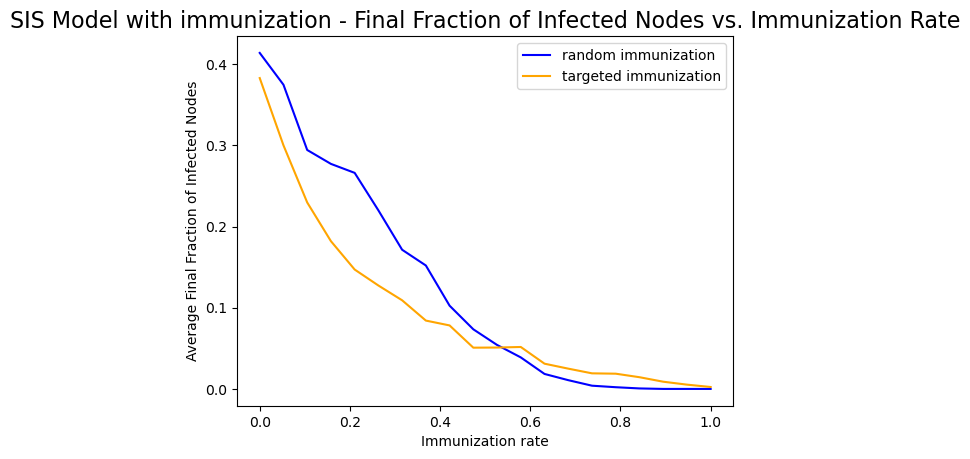

In [5]:
plt.plot(g_values, avg_final_infected_random, color = 'blue', label='random immunization')
plt.plot(g_values, avg_final_infected_target, color = 'orange', label='targeted immunization')

# Add labels and title
plt.xlabel('Immunization rate')
plt.ylabel('Average Final Fraction of Infected Nodes')
plt.title('SIS Model with immunization - Final Fraction of Infected Nodes vs. Immunization Rate', fontsize=16)

# Add legend
plt.legend()

plt.legend()
plt.show()

## Task 2: Centralities and influence

### 1.
We write functions to simulate the SIR model over 1000 periods, and visualize the network with each node's spreading ability $Q_i$.

In [856]:
def sir_model_simulation(G, beta, gamma, infected_node):
    """
    Simulate SIR dynamics on a network. 

    Parameters:
    - G: NetworkX graph
    - beta: infection rate
    - gamma: recovery rate
    - infected_node: node infected at t=0
    """

    # Initialize states
    nodes = set(G.nodes())
    susceptible_nodes = set(G.nodes())
    susceptible_nodes.remove(infected_node)

    states = {
        'susceptible': susceptible_nodes,
        'infected': set([infected_node]),
        'recovered': set()
    }

    # Compute dictionary of neighbors
    neighbor_sets = {node: set(G.neighbors(node)) for node in G.nodes}

    # Simulate 1000 periods
    for i in range(1000):

        # Instantiate variable for states at the beginning of t to use for reference
        states_t = states.copy()
        
        # Interrupt simulation if there are no more infected nodes
        if len(states_t['infected']) == 0:
            break

        # Iterate through nodes
        for n in nodes:

            # If susceptible at t, calculate infection probability
            if n in states_t['susceptible']:
                v = len(neighbor_sets[n] & states_t['infected'])
                inf_prob = 1-(1-beta)**v

                # If infected, move to "infected" in states dictionary, not states_t
                if np.random.rand() <= inf_prob:
                    states['susceptible'].remove(n)
                    states['infected'].add(n)
            
            # If infected at t, simulate recovery probability
            elif n in states_t['infected']:
                if np.random.rand() <= gamma:
                    # If recovered, move to "recovered" in states dictionary, not states_t
                    states['infected'].remove(n)
                    states['recovered'].add(n)
    
    # Compute rho_p, the share of recovered nodes in the final state
    rho_p = len(states['recovered'])/len(nodes)

    return rho_p

def get_Qi(G, beta, gamma, repetitions = 150):
    """
    Compute Q_i for each node of the network. 

    Parameters:
    - G: NetworkX graph
    - beta: infection rate
    - gamma: recovery rate
    """

    # Initialize empty dict 
    Qi = {}

    # Run simulation with each node in G as infected node as many times as indicated by repetitions variable
    for n in tqdm(G.nodes()):
        Qi_lst = []

        for i in range(repetitions):
            Qi_lst.append(sir_model_simulation(G, beta, gamma, n))
        
        # Calculate average Qi for each node and store in dict
        Qi[n] = np.average(Qi_lst)
    
    return Qi


def plot_Qi(G, repetitions = 1000):
    """
    Plot network with node color as a function of its Q_i at the epidemic threshold.

    Parameters:
    - G: NetworkX graph
    """

    # Compute beta/gamma above epidemic threshold (lambda_C = 1/(⟨k⟩/⟨k²⟩-1))
    avg_k = np.mean([d for n, d in G.degree()])
    avg_k_sq = np.mean([d**2 for n, d in G.degree()])
    lambda_ep = 1/((avg_k_sq/avg_k)-1)

    # Compute a possible beta and gamma pair at the epidemic threshold
    beta = lambda_ep / (1 + lambda_ep)
    gamma = 1 / (1 + lambda_ep)
    
    # Obtain Qi from get_Qi()
    Qi = get_Qi(G, beta, gamma, repetitions)

    # Visualize Graph with continuous colorbar for nodes given by their Qi value
    pos = nx.kamada_kawai_layout(G)
    nx.draw_networkx_edges(G, pos, width = 0.1)
    nc=nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color=list(Qi.values()), node_size= 50, cmap=plt.cm.jet)
    cb=plt.colorbar(nc, label='$Q_i$')
    plt.axis('off')
    plt.title(r'$\beta=$'+str(np.round(beta*10000)/100)+r'%, $\gamma=$'+str(np.round(gamma,4)*100)+'%')
    plt.show()

We now simulate the SIR dynamic and visualize the following graphs at the epidemic threshold $\lambda_C$.

In [857]:
# Generate graphs
BA_graph = nx.barabasi_albert_graph(100, 3)
oneD_lattice_graph = nx.watts_strogatz_graph(100, 6, 0)

#### Barabasi-Albert network

100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


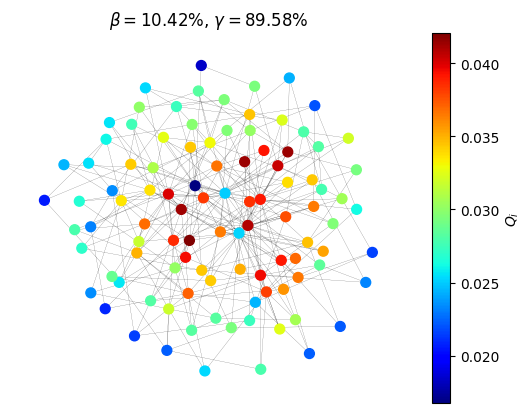

In [805]:
plot_Qi(BA_graph)

#### 1D regular lattice with periodic condition

100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


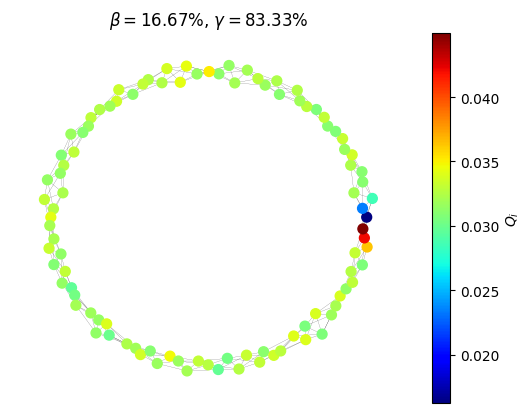

In [858]:
plot_Qi(oneD_lattice_graph)

### 2.

We write functions to obtain and plot Spearman correlation coefficients between $Q_i$ and degree, closeness, PageRank, and k-core centralities as a function of $\frac{\beta}{\gamma}$.

In [811]:
def get_Qi_and_centralities(G, repetitions = 150, exercise4 = False):
    """
    Compute Q_i and centrality scores for each node of the network
    as a function of beta/gamma in range [0.25,4]*lambda_c. 

    Parameters:
    - G: NetworkX graph
    - repetitions: number of simulations
    - exercise4: boolean for exercise 4 (reduced version if True)
    """

    # Compute four centralities
    deg = nx.degree_centrality(G)
    clos = nx.closeness_centrality(G)
    pager = nx.pagerank(G)
    kcor = nx.core_number(G)
    
    # Compute epidemic threshold as lambda_C = 1/(⟨k⟩/⟨k²⟩-1)
    avg_k = np.mean([d for n, d in G.degree()])
    avg_k_sq = np.mean([d**2 for n, d in G.degree()])
    ep_thresh = 1/((avg_k_sq/avg_k) -1)

    if exercise4:
        # Only run for the epidemic threshold
        ratios = [ep_thresh]
    else:
        # Compute ratios as [0.25, 4] * lambda_C
        ratios = np.arange(0.25, 4.1, 0.25)*ep_thresh

    Qi_dict = {}

    for r in tqdm(ratios):
        # Set beta and gamma between 0 and 1 to have correct ratio
        beta = r / (1 + r)
        gamma = 1 / (1 + r)

        # Obtain Qi 
        Qi_dict[r] = get_Qi(G, beta, gamma, repetitions)
    
    # Package and return obtained values
    output = [deg, clos, pager, kcor, Qi_dict, ep_thresh]
        

    return output

def plot_centralities_corr(input):
    """
    Plot correlations between Q_i and centrality measures as a function of beta\gamma 

    Parameters:
    - input: array containing centrality and Q_i scores, as well as the epidemic threshold
    """

    # Unpack elements of input
    deg = input[0]
    clos = input[1]
    pager = input[2]
    kcor = input[3]
    Qi_dict = input[4]
    ep_thresh = input[5]

    # Extract values from dictionary
    deg_lst = list(deg.values())
    clos_lst = list(clos.values())
    pager_lst = list(pager.values())
    kcor_lst = list(kcor.values())

    # Extract ratios from dictionary
    ratios = list(Qi_dict.keys())

    # Initialize empty arrays for correlations
    deg_corr = []
    clos_corr = []
    pager_corr = []
    kcor_corr = []
    # Iterate through ratios
    for r in ratios:

        # Obtain Q_i values for given ratio
        Qi_lst = list(Qi_dict[r].values())

        # Compute correlations and append to respective arrays
        deg_corr.append(st.spearmanr(deg_lst, Qi_lst).statistic)
        clos_corr.append(st.spearmanr(clos_lst, Qi_lst).statistic)
        pager_corr.append(st.spearmanr(pager_lst, Qi_lst).statistic)
        kcor_corr.append(st.spearmanr(kcor_lst, Qi_lst).statistic)
    
    # Get minimum and maximum values considering all correlations
    y_max = max([max(deg_corr), max(clos_corr), max(pager_corr), max(kcor_corr)])
    y_min = min([min(deg_corr), min(clos_corr), min(pager_corr), min(kcor_corr)])


    # Plot correlations against ratios
    plt.plot(ratios, deg_corr, marker='o', label ='Degree')
    plt.plot(ratios, clos_corr, marker='o', label ='Closeness')
    plt.plot(ratios, pager_corr, marker='o', label ='PageRank')
    plt.plot(ratios, kcor_corr, marker='o', label ='K-core')
    plt.vlines(ep_thresh, y_min, y_max, linestyles='dashed', colors='purple', label = r'$\lambda_C=$'+str(np.round(ep_thresh,4)))
    plt.xlabel(r'$\frac{\beta}{\gamma}$')
    plt.ylabel(r'Spearrman correlation')
    plt.title(r'Correlation between centralities and $Q_i$')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

We now compute and visualize the scores for the following graphs.

In [737]:
# Generate graphs
BA_graph = nx.barabasi_albert_graph(100, 3)
ER_graph = nx.gnp_random_graph(100, 0.06)
WS_graph = nx.watts_strogatz_graph(100, 6, 0.02)

In [812]:
# Compute Q_i and centrality measures for the graphs
BA_graph_output = get_Qi_and_centralities(BA_graph)
ER_graph_output = get_Qi_and_centralities(ER_graph)
WS_graph_output = get_Qi_and_centralities(WS_graph)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 16/16 [02:33<00:00,  9.59s/it]


#### Barabasi-Albert network

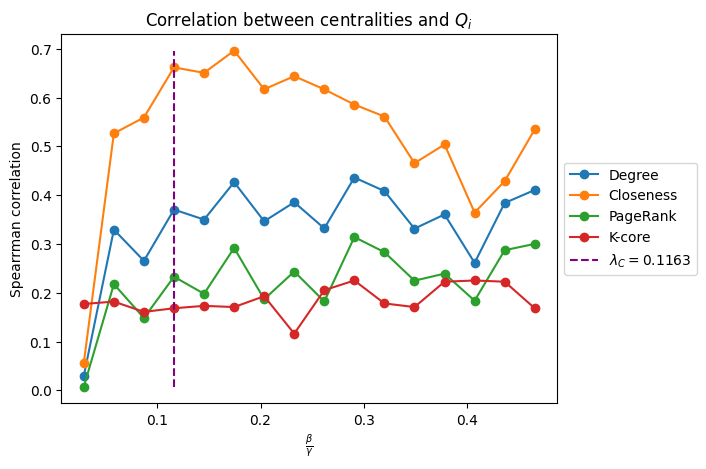

In [813]:
plot_centralities_corr(BA_graph_output)

#### Erdos-Renyi network

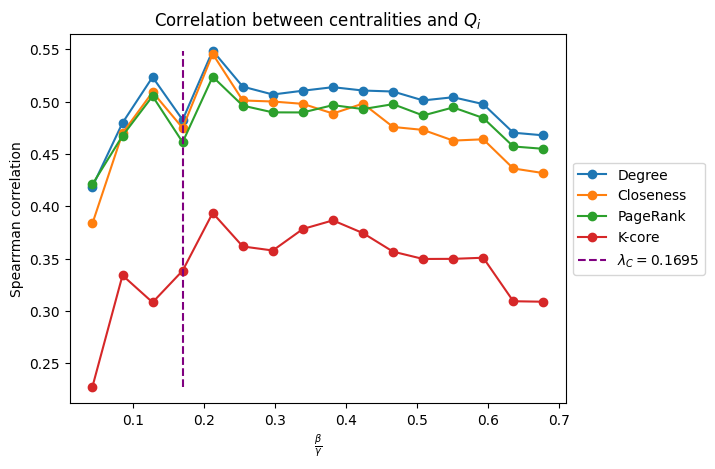

In [814]:
plot_centralities_corr(ER_graph_output)

#### Watts-Strogatz network

C:\Users\stopp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


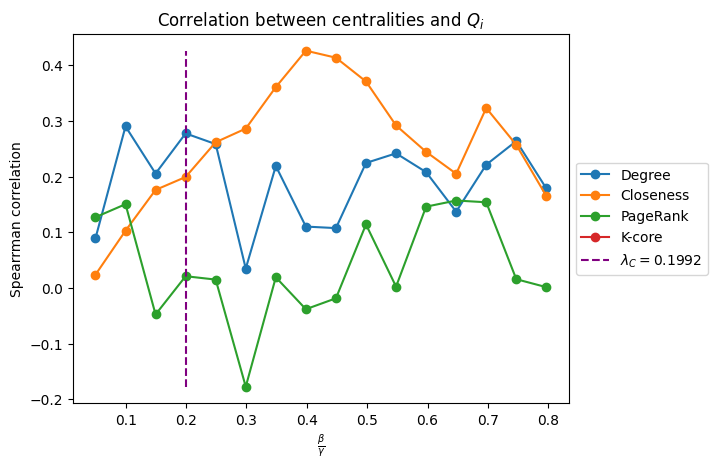

In [815]:
plot_centralities_corr(WS_graph_output)

The K-core centrality and $Q_i$ correlation cannot be computed for this graph as the centrality score is always constant.

### 3.

We write functions to obtain and scatter plot the normalized spreading ability $Q_i$ against normalized degree, closeness, PageRank, and K-core centralities at the epidemic threshold $\lambda_C$.

In [828]:
def normalize(lst):
    """
    normalize array by dividing for the largest value in it 

    Parameters:
    - input: array to normalize
    """
    lst_stand = lst/max(lst)
    return lst_stand

def plot_scatter_centralities_qi(input):
    """
    Scatter plot Q_i and centrality measures at the epidemic threshold

    Parameters:
    - input: array containing centrality and Q_i scores, as well as the epidemic threshold
    """

    # Extract elements in input
    deg = input[0]
    clos = input[1]
    pager = input[2]
    kcor = input[3]
    Qi_dict = input[4]
    ep_thresh = input[5]

    # normalize elements
    deg_stand = normalize(np.array(list(deg.values())))
    clos_stand = normalize(np.array(list(clos.values())))
    pager_stand = normalize(np.array(list(pager.values())))
    kcor_stand = normalize(np.array(list(kcor.values())))
    Qi_stand = normalize(np.array(list(Qi_dict[ep_thresh].values())))

    # Scatter plot normalized values of Q_i vs centrality separately
    fig, axs = plt.subplots(2, 2)
    fig.tight_layout(h_pad=3, w_pad=3)
    fig.suptitle(r'Centralities and Spreading ability ($Q_i$) at $\lambda_C=$'+str(np.round(ep_thresh,4)), y=1.05)
    
    axs[0,0].scatter(deg_stand, Qi_stand, c='blue')
    axs[0,0].set_ylabel(r'$Q_i$')
    axs[0,0].set_xlabel('Degree centrality')

    axs[0,1].scatter(clos_stand, Qi_stand, c='green')
    axs[0,1].set_ylabel(r'$Q_i$')
    axs[0,1].set_xlabel('Closeness centrality')

    axs[1,0].scatter(pager_stand, Qi_stand, c='purple')
    axs[1,0].set_ylabel(r'$Q_i$')
    axs[1,0].set_xlabel('PageRank centrality')

    axs[1,1].scatter(kcor_stand, Qi_stand, c='red')
    axs[1,1].set_ylabel(r'$Q_i$')
    axs[1,1].set_xlabel('K-core centrality')

#### Barabasi-Albert network

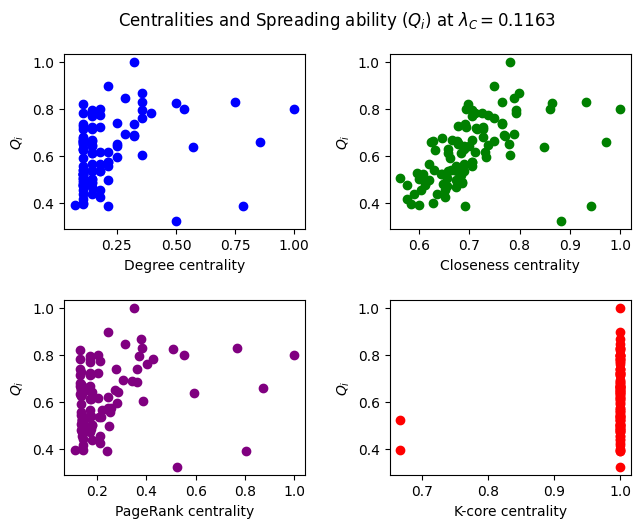

In [829]:
plot_scatter_centralities_qi(BA_graph_output)

#### Erdos-Renyi network

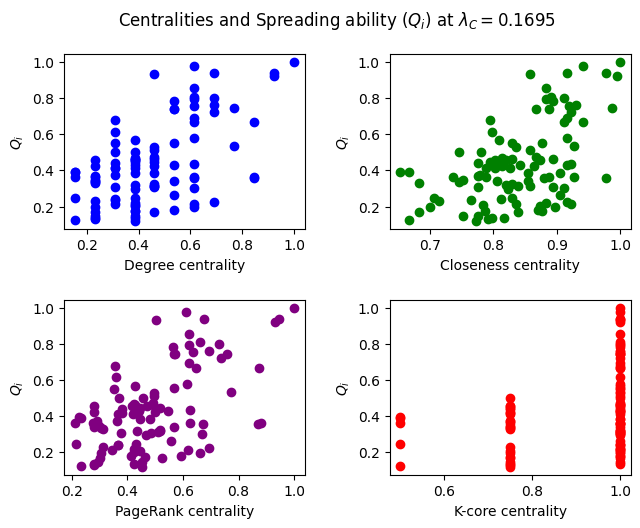

In [830]:
plot_scatter_centralities_qi(ER_graph_output)

#### Watts-Strogatz network

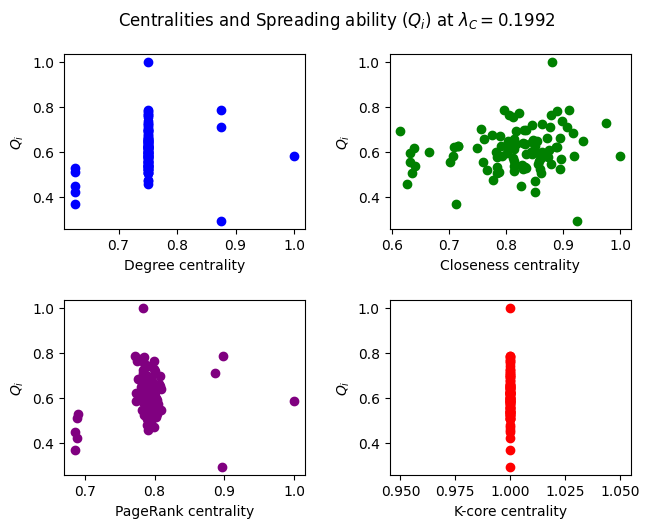

In [831]:
plot_scatter_centralities_qi(WS_graph_output)

### 4.

We now reproduce the previous scatter plots for the real-life data sets provided.

In [822]:
jazz_graph_output = get_Qi_and_centralities(jazz, 2000, True)
madrid_graph_output = get_Qi_and_centralities(madrid, 2000, True)

100%|██████████| 1/1 [00:20<00:00, 20.56s/it]


#### Jazz collaborations network

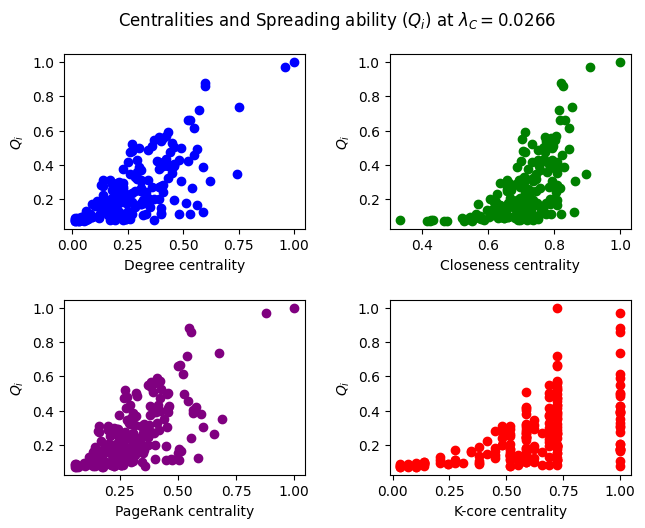

In [832]:
plot_scatter_centralities_qi(jazz_graph_output)

#### Madrid train bombing terrorists network

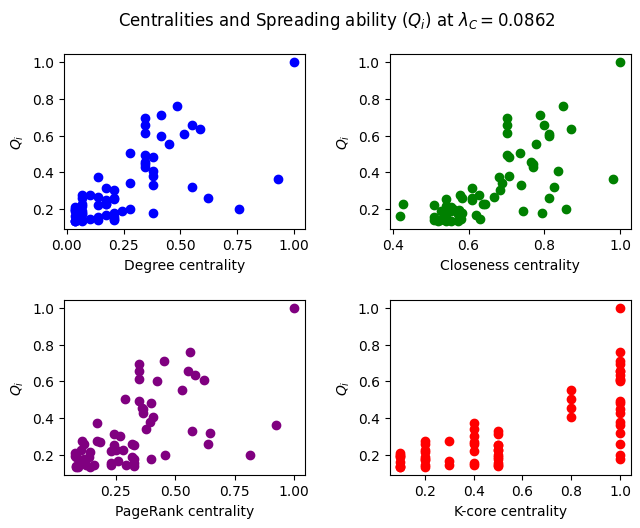

In [833]:
plot_scatter_centralities_qi(madrid_graph_output)

Both real-world networks have individuals as nodes, and their collaborations/interactions as edges, which explains the fact that their respective scatter plots are quite similar. Unsurprisingly, from the plots we observe a marked positive relationship between the values of a node's centrality measures and its spreading ability. In other words, an infection spreads better when it starts from a node that is more important, or better connected in the network. 

The main difference between the scatter plots  of the two networks is the gap between the top spreaders and the rest of the nodes:
1. The larger gap for the Madrid terrorist network suggests the existence of a core group of terrorists which was connected to various smaller and more isolated cells or individuals, that had few to no interactions with each other. This sounds reasonable, as it was in the interest of the terrorists to limit contacts among them as much as possible, in order to reduce the risk of the whole network being dismantled in case a single element was compromised.

2. The smaller gap for the Jazz collaborations network can instead be explained by the network being more connected. In other words, famous artists not only collaborate with other famous artists, but also with less known ones. In turn, the latter collaborate a lot among each other, so that there are less highly isolated nodes, as opposed to the terrorist network case.

A visual inspection of the two graphs (see below) confirms that the jazz network is more cohesive than the Madrid terrorists one. Furthermore, the fact that it is easier for an epidemic to spread in a more connected graph is proven by the epidemic threshold of the jazz network being lower than that of the Madrid terrorist network ($\lambda_{C,Jazz}=0.0266$ vs. $\lambda_{C,Madrid}=0.0862$).


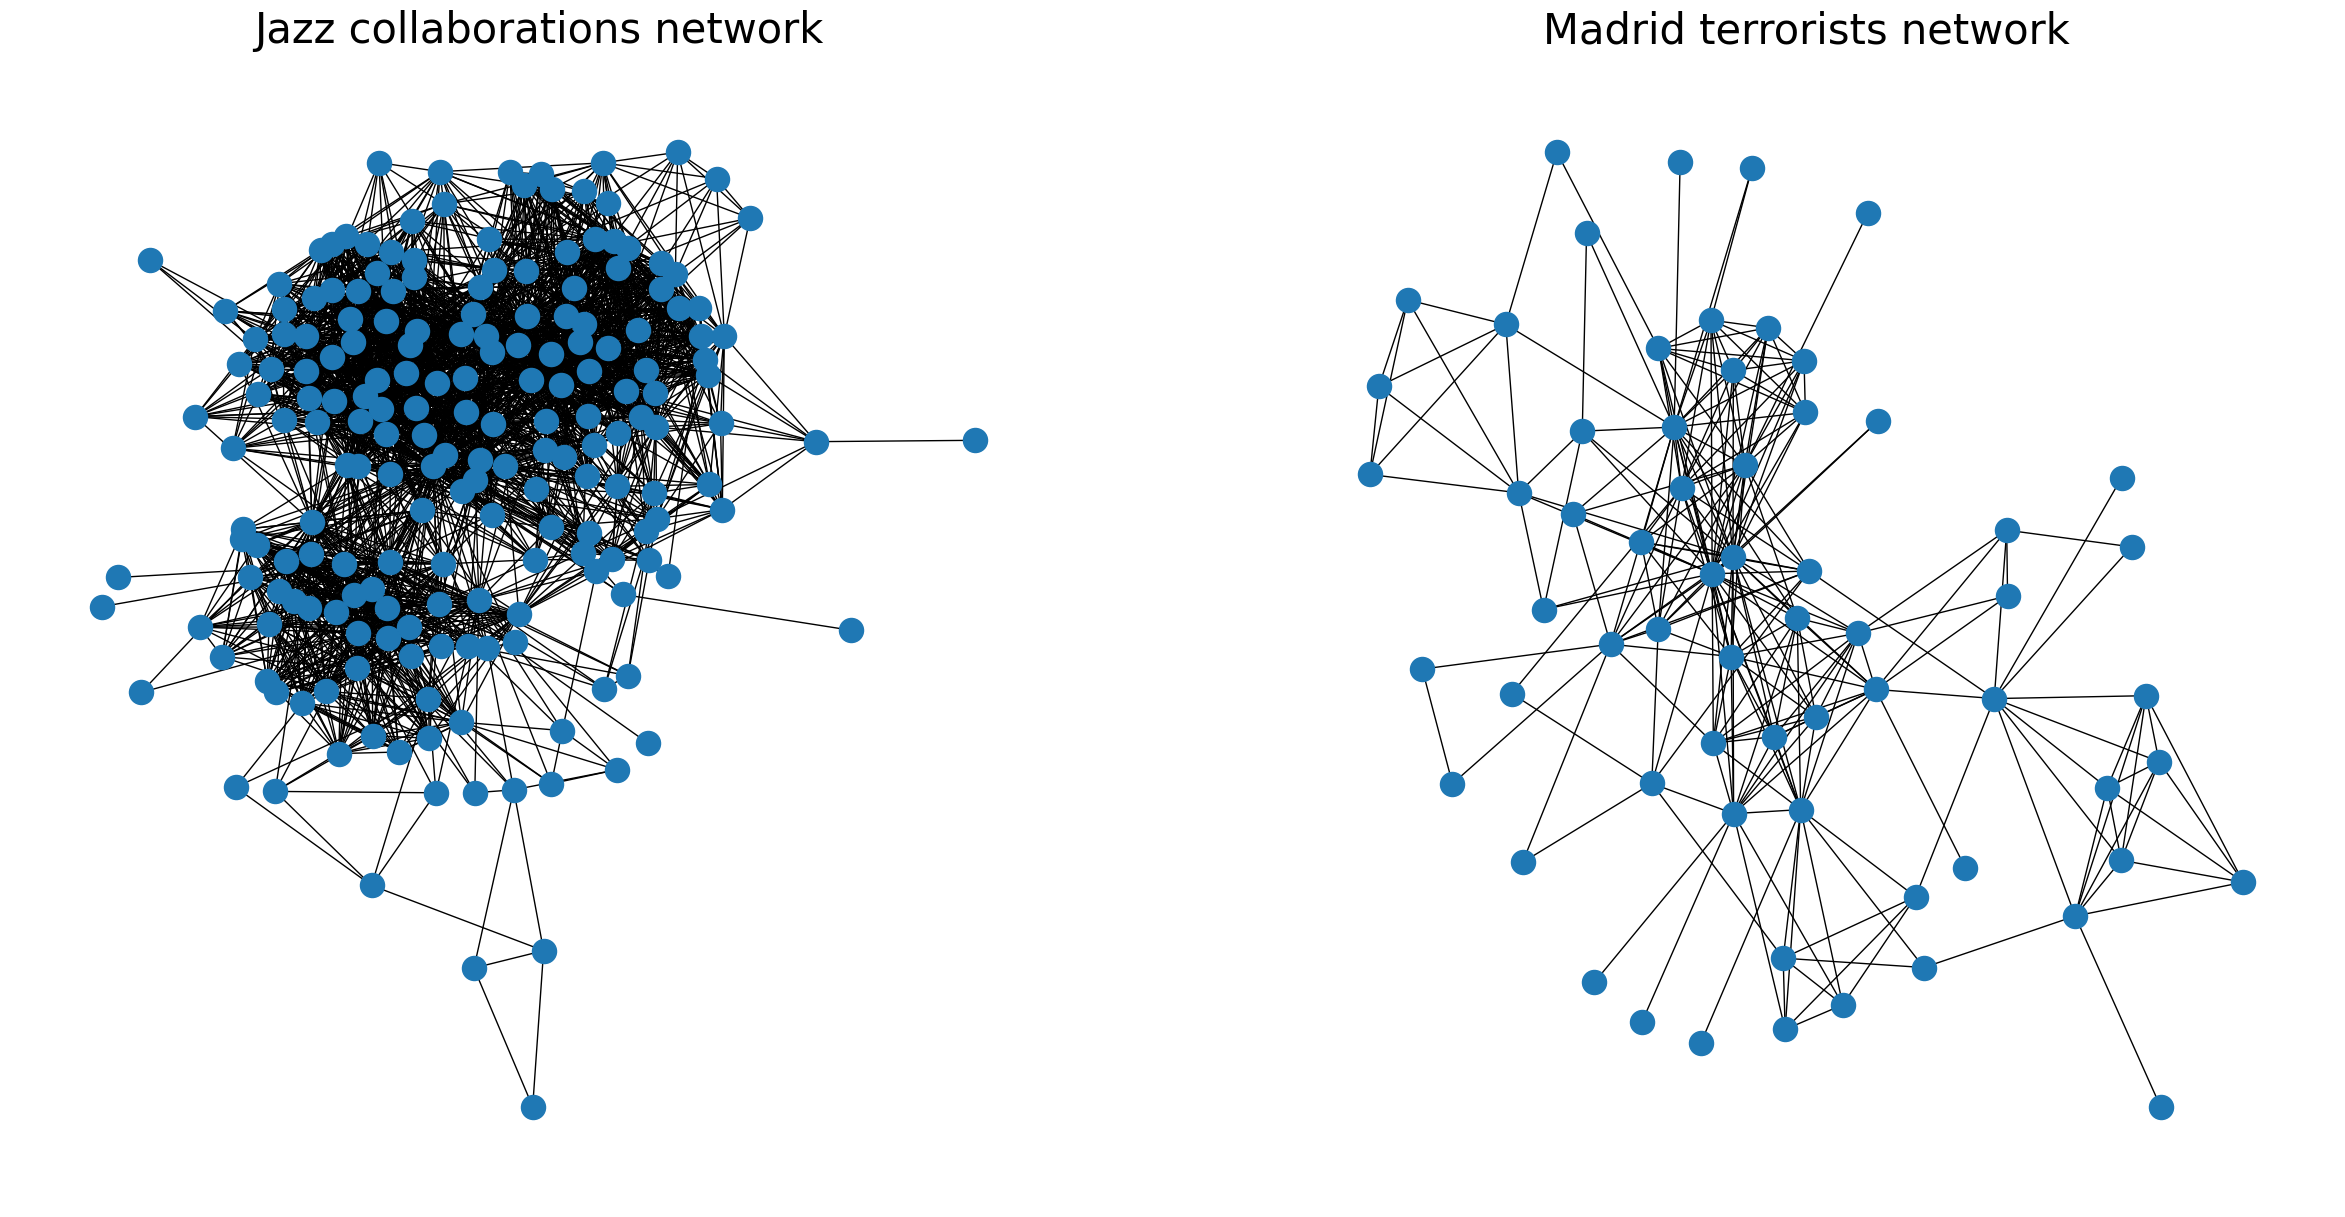

In [903]:
fig, axs = plt.subplots(1, 2, figsize=(30, 15))

plt.sca(axs[0])
nx.draw_networkx_nodes(jazz, pos=nx.kamada_kawai_layout(jazz), ax=axs[0])
nx.draw_networkx_edges(jazz, pos=nx.kamada_kawai_layout(jazz), ax=axs[0])
axs[0].set_title('Jazz collaborations network', fontsize=30)
axs[0].set_axis_off()

plt.sca(axs[1])
nx.draw_networkx_nodes(madrid, pos=nx.kamada_kawai_layout(madrid), ax=axs[1])
nx.draw_networkx_edges(madrid, pos=nx.kamada_kawai_layout(madrid), ax=axs[1])
axs[1].set_title('Madrid terrorists network', fontsize=30)
axs[1].set_axis_off()

